## Get Data

In [1]:
from get_data import *

In [3]:
heads,desc = import_from_mongo()

## Build Vocab

In [6]:
FN = 'vocabulary-embedding'
seed = 42
vocab_size = 40000
embedding_dim = 100
lower = False

In [7]:
if lower:
    heads = [h.lower() for h in heads]
    desc = [h.lower() for h in desc]

In [8]:
from collections import Counter
from itertools import chain

def get_vocab(lst):
    vocabcount = Counter(w for txt in lst for w in txt.split())
    vocab = map(lambda x: x[0], sorted(vocabcount.items(), key = lambda x: -x[1]))
    return list(vocab),vocabcount

In [9]:
vocab,vocabcount = get_vocab(heads+desc)

In [10]:
print(vocab[:50])

print(len(vocab))

['the', 'and', 'to', 'of', 'a', 'that', 'I', 'in', 'you', 'is', 'we', 'it', 'this', 'was', 'for', 'are', 'have', 'so', 'with', 'on', 'they', 'what', 'my', 'be', 'can', 'And', 'but', 'about', 'as', 'not', 'at', 'all', 'do', 'like', "it's", 'our', 'from', 'or', 'one', 'people', 'an', 'just', 'if', 'when', 'your', 'me', 'because', 'these', 'by', 'how']
203554


In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

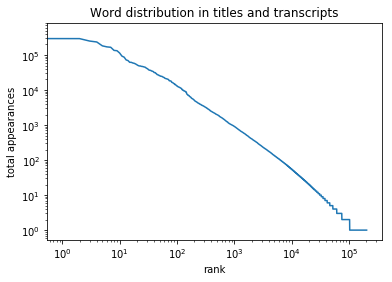

In [12]:
plt.plot([vocabcount[w] for w in vocab])
plt.gca().set_xscale('log',nonposx='clip')
plt.gca().set_yscale('log',nonposy='clip')
plt.title('Word distribution in titles and transcripts')
plt.xlabel('rank')
plt.ylabel('total appearances')
plt.show()

## Index Words

In [14]:
empty = 0
eos = 1
start_idx = eos + 1

In [15]:
def get_idx(vocab,vocabcount):
    word2idx = dict((word, idx+start_idx) for idx,word in enumerate(vocab))
    word2idx['<empty>'] = empty
    word2idx['<eos>'] = eos
    
    idx2word = dict((idx,word) for word, idx in word2idx.items())
    
    return word2idx, idx2word

In [16]:
word2idx, idx2word = get_idx(vocab,vocabcount)

## Word Embedding with GloVe

In [46]:
#path for the glove file with vectors of length 100
glove_name = 'glove/glove.6B.{0}d.txt'.format(embedding_dim)

In [47]:
#get the length of the glove file
glove_n_symbols = !wc -l {glove_name}
glove_n_symbols = int(glove_n_symbols[0].split()[0])
glove_n_symbols

400000

In [35]:
#create two dictionaries:  glove_index_dict for the words and indices
                        #. glove_embedding_weights for the weights in the glove file 
    
glove_index_dict = {}                        
glove_embedding_weights = np.empty((glove_n_symbols, embedding_dim))
#scale by .1
global_scale=.1
with open('glove/glove.6B.100d.txt', 'r') as fp:
    i = 0
    for l in fp:
        l = l.strip().split()
        w = l[0]
        #for each word in the glove file, add with index to the index dict
        glove_index_dict[w] = i
        #then add weights to the weights dict
        glove_embedding_weights[i,:] = list(map(float,l[1:]))
        i += 1
glove_embedding_weights *= global_scale

In [42]:
for w,i in glove_index_dict.items():
    w = w.lower()
    if w not in glove_index_dict:
        glove_index_dict[w] = i

## Use GloVe to create the embeding matrix

In [48]:
#generate random embedding with the scale of glove

np.random.seed(seed)
shape = (vocab_size,embedding_dim)
scale = glove_embedding_weights.std()*np.sqrt(12)/2
embedding = np.random.uniform(low=-scale,high=scale,size=shape)
print('random embedding/glove scale',scale, 'std', embedding.std())

random embedding/glove scale 0.0706949139514209 std 0.04081382495746382


In [54]:
#get weights for the words in our vocab
c = 0

for i in range(vocab_size):
    w = idx2word[i]
    g = glove_index_dict.get(w,glove_index_dict.get(w.lower()))
    if g is not None:
        embedding[i,:] = glove_embedding_weights[g,:]
        c += 1
print('number of tokens, in small vocab, found in glove and copied to embedding', c,c/float(vocab_size))


number of tokens, in small vocab, found in glove and copied to embedding 26199 0.654975


In [56]:
#lots of words in the vocabulary are outsise the vocab size
#map them to their closest word if their cosine distance is close enough
glove_thr = 0.5
word2glove = {}

for w in word2idx:
    if w in glove_index_dict:
        g = w
    elif w.lower() in glove_index_dict:
        g = w.lower()
    else:
        continue
    word2glove[w] = g
        

In [59]:
normed_embedding = embedding/np.array([np.sqrt(np.dot(gweight,gweight)) for gweight in embedding])[:,None]

nb_unknown_words = 100

glove_match = []

for w,idx in word2idx.items():
    if idx >= vocab_size - nb_unknown_words and w.isalpha() and w in word2glove:
        gidx = glove_index_dict[word2glove[w]]
        gweight = glove_embedding_weights[gidx,:].copy()
        #find row in weights that has the highest cos score with gweights
        gweight /= np.sqrt(np.dot(gweight,gweight))
        score = np.dot(normed_embedding[:vocab_size-nb_unknown_words],gweight)
        while True:
            embedding_idx = score.argmax()
            s = score[embedding_idx]
            if s < glove_thr:
                break
            if idx2word[embedding_idx] in word2glove:
                glove_match.append((w,embedding_idx,s))
                break
            score[embedding_idx] = -1
            
glove_match.sort(key = lambda x: -x[2])
print('# of substitues found',len(glove_match))

# of substitues found 41880


In [64]:
for orig,sub,score in glove_match[-10:]:
    print(score,orig,'=>' ,idx2word[sub])

0.5000977260520658 Krispies => tapioca
0.5000942943849462 eyelets => three-meter
0.5000787995235627 menstruating => menstruation
0.5000436838232105 scoping => sketching
0.5000435699449621 Gilding => embellishments
0.5000330391740313 Geneviève => rol
0.5000302493948421 ghostwriter => co-author
0.5000076693054036 handpicked => electors
0.5000055595011661 cheapskate => dude
0.5000054542906212 spry => astonishingly


In [65]:
glove_idx2idx = dict((word2idx[w],embedding_idx) for w, embedding_idx, _ in glove_match)

In [67]:
Y = [[word2idx[token] for token in headline.split()] for headline in heads]

In [68]:
len(Y)

5858

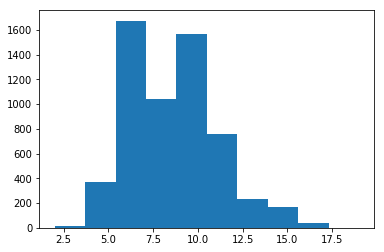

In [75]:
plt.hist(list(map(len,Y)));

In [76]:
X = [[word2idx[token] for token in d.split()] for d in desc]

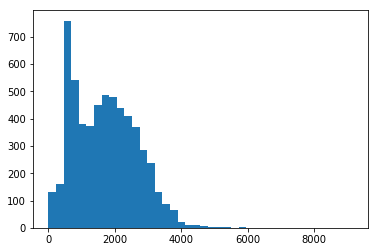

In [79]:
plt.hist(list(map(len,X)),bins=40);

In [80]:
import pickle

In [82]:
with open('%s.pkl'%FN,'wb') as fp:
    pickle.dump((embedding, idx2word, word2idx, glove_idx2idx),fp,-1)